## the bottleneck model to tackle 250 products

In [1]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

start_time = time.time()

N_prod = 250        # number of products
Vec_Len = N_prod + 1
Neck_Len = 30       # bottle neck width
EPOCHS = 600
SAMPLE_AMOUNT = 100000
BATCH_SIZE = 5000
TRAIN_VALI_RATE = 0.9
ADAM_LR = 0.0005

# generate latent parameters
transP = MG.GenMarkovM(
    product_num = N_prod,
    gen_func = lambda x : MG.GenTransprob_Sparse(x)
)
lams = np.random.uniform(low = 0, high = 1, size = N_prod)
lams = lams / sum(lams)

# generate synthetic data
INPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
for i in range(SAMPLE_AMOUNT):
    
    # generate input vector, which has length vec_len
    # the first element is 0, which should be ignored when treated as an assortment
    assort = AG.GenAssortment_Sparse(N_prod)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)

print("data generated!")
print("total time elapse : ",time.time()-start_time)

train_dataset = TensorDataset(torch.Tensor(INPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]),torch.Tensor(OUTPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]))    
vali_dataset = TensorDataset(torch.Tensor(INPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]),torch.Tensor(OUTPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]))    

train_loader = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE)
vali_loader = DataLoader(vali_dataset, shuffle=True, batch_size = len(vali_dataset))

model = Models.Bottleneck(Vec_Len, Neck_Len)
optimizer = optim.Adam(model.parameters(), lr = ADAM_LR)
criterion = nn.BCELoss()

training_losses = []
vali_losses = []

for epo in range(1,EPOCHS+1):
    if epo % 50 == 0:
        print("epoch : ",epo)
    for step, (IN, TEST) in enumerate(train_loader):
        
        OUT = model(IN)
        loss = criterion(OUT,TEST)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_pure = loss.detach().item()
        loss_base = criterion(TEST,TEST).detach().item()
        training_losses.append((loss_pure - loss_base)/loss_base)
        
    for step, (VALI_IN, VALI_TEST) in enumerate(vali_loader):
        VALI_OUT = model(VALI_IN)
        loss = criterion(VALI_OUT,VALI_TEST)

        loss_pure = loss.detach().item()
        loss_base = criterion(VALI_TEST,VALI_TEST).detach().item()
        vali_losses.append((loss_pure - loss_base)/loss_base)

np.save('EXP2_dump/markov_matrix',transP)
np.save('EXP2_dump/arriving_lambda',lams)
np.save('EXP2_dump/bottleneck_train_loss', training_losses)
np.save('EXP2_dump/bottleneck_vali_loss', vali_losses)
torch.save(model, "EXP2_dump/bottleneck_model.pth")

data generated!
total time elapse :  122.86280179023743
epoch :  50
epoch :  100
epoch :  150
epoch :  200
epoch :  250
epoch :  300
epoch :  350
epoch :  400
epoch :  450
epoch :  500
epoch :  550
epoch :  600


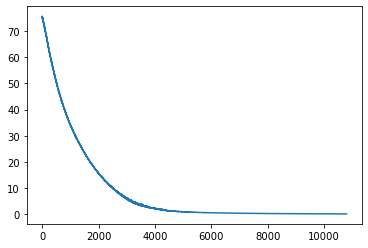

In [2]:
train_loss = np.load('EXP2_dump/bottleneck_train_loss.npy')
plt.plot(train_loss)

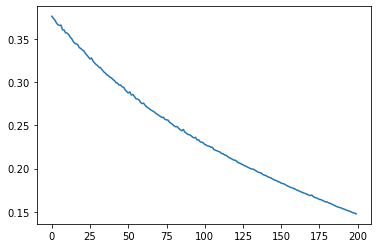

In [4]:
import numpy as np
import matplotlib.pyplot as plt

vali_loss = np.load('EXP2_dump/bottleneck_vali_loss.npy')
plt.plot(vali_loss[400:])

## We ask, why would this loss go all the way to nearly 0?

(array([ 2.,  3.,  5., 11., 13., 22., 23.,  8.,  8.,  5.]),
 array([0.00489897, 0.00554083, 0.00618268, 0.00682454, 0.00746639,
        0.00810825, 0.0087501 , 0.00939196, 0.01003381, 0.01067567,
        0.01131752]),
 <BarContainer object of 10 artists>)

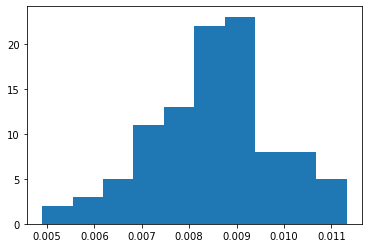

In [9]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

N_prod = 250        # number of products
Vec_Len = N_prod + 1

SAMPLE_AMOUNT = 100

# generate latent parameters
transP = MG.GenMarkovM(
    product_num = N_prod,
    gen_func = lambda x : MG.GenTransprob_Sparse(x)
)
lams = np.random.uniform(low = 0, high = 1, size = N_prod)
lams = lams / sum(lams)

# generate synthetic data
INPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))

OUTPUT_BCE = np.zeros(SAMPLE_AMOUNT)

num_assort = np.zeros(SAMPLE_AMOUNT)
for i in range(SAMPLE_AMOUNT):
    
    assort = AG.GenAssortment_Sparse(N_prod)
    num_assort[i] = sum(assort)
    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)
    
    s=0
    for p in OUTPUT[i]:
        if p > 1e-6 and p < 1-1e-6:
            s += -p*np.log(p) - (1-p)*np.log(1-p)
            
    OUTPUT_BCE[i] = s/Vec_Len

plt.hist(OUTPUT_BCE)
